In [ ]:
# Run this cell first, and restart the environment. Then run the second cell onwards.
!pip install --upgrade --force-reinstall \
    numpy==1.26.4 pandas==2.2.2 \
    transformers sentence-transformers \
    textattack datasets nltk matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 915.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 82.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 63.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) .

In [ ]:
# === Imports and Setup ===
from transformers import pipeline
import os
import torch
import nltk
import re
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from textattack.augmentation.recipes import WordNetAugmenter, CharSwapAugmenter, CLAREAugmenter
from nltk.corpus import wordnet

In [ ]:
# === Configure Environment ===
HF_TOKEN = ""
os.environ["HF_TOKEN"] = HF_TOKEN

# === Download WordNet Resources ===
nltk.download('omw-1.4')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/omw-1.4.zip -d /usr/share/nltk_data/corpora > /dev/null
! mv /usr/share/nltk_data/corpora/omw-1.4 /usr/share/nltk_data/corpora/omw
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

# === Load Model Pipeline ===
model_id = "ContactDoctor/Bio-Medical-Llama-3-8B"
device = 0  # CUDA 0 (use -1 for CPU)

qa_pipeline = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto"
)

semantic_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


unzip:  cannot find or open /usr/share/nltk_data/corpora/omw-1.4.zip, /usr/share/nltk_data/corpora/omw-1.4.zip.zip or /usr/share/nltk_data/corpora/omw-1.4.zip.ZIP.


[nltk_data]   Package wordnet is already up-to-date!


mv: cannot stat '/usr/share/nltk_data/corpora/omw-1.4': No such file or directory
unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/53.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

Device set to use cuda:0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# === Extract A/B/C/D Letter from Model Output ===
def extract_answer_letter(text):
    match = re.search(r"\b([A-D])\b", text.upper())
    return match.group(1) if match else ""

# === Load MedMCQA Dataset (random 100 single-choice questions) ===
dataset = load_dataset("medmcqa", split="validation")
dataset = dataset.filter(lambda example: example["choice_type"] == "single")
dataset = dataset.shuffle(seed=42).select(range(100))

questions = [ex["question"] for ex in dataset]
options_list = [[ex["opa"], ex["opb"], ex["opc"], ex["opd"]] for ex in dataset]
correct_indices = [int(ex["cop"]) for ex in dataset]
correct_letters = [chr(ord('A') + idx) for idx in correct_indices]

# === Build original prompts once ===
def build_prompt(question_text, opts):
    return (
        "You are a knowledgeable medical expert. Read the following question carefully and choose the most appropriate answer from the options provided. "
        "Respond with only the letter corresponding to your answer choice (A, B, C or D).\n\n"
        f"Question:\n{question_text}\n\n"
        f"Options:\n"
        f"A. {opts[0]}\n"
        f"B. {opts[1]}\n"
        f"C. {opts[2]}\n"
        f"D. {opts[3]}\n\n"
        "Answer:"
    )

original_prompts = [build_prompt(q, opts) for q, opts in zip(questions, options_list)]
orig_outputs = qa_pipeline(original_prompts, max_new_tokens=30)

original_letters = []
original_correct_flags = []

for i in range(len(questions)):
    response = orig_outputs[i][0]['generated_text'].replace(original_prompts[i], "").strip()
    letter = extract_answer_letter(response)
    original_letters.append(letter)
    original_correct_flags.append(int(letter == correct_letters[i]))

print("Original model predictions saved successfully.")

# === Perturbation Parameters ===
perturbation_levels = [0.3, 0.5, 0.7, 0.9]
batch_size = 8
all_results = []

# === Perturbation Loop ===
for perturbation_level in perturbation_levels:
    print(f"\n=== Evaluating Perturbation Level: {int(perturbation_level * 100)}% ===")

    wordnet_augmenter = WordNetAugmenter(pct_words_to_swap=perturbation_level)
    char_swap_augmenter = CharSwapAugmenter(pct_words_to_swap=perturbation_level)
    clare_augmenter = CLAREAugmenter(transformations_per_example=1)

    total_questions = 0
    correct_original = 0
    correct_word_perturbed = 0
    correct_char_perturbed = 0
    correct_clare_perturbed = 0
    results = []

    for start_idx in tqdm(range(0, len(questions), batch_size), desc=f"Perturb {int(perturbation_level * 100)}%", unit="batch"):
        end_idx = min(start_idx + batch_size, len(questions))

        q_batch = questions[start_idx:end_idx]
        opts_batch = options_list[start_idx:end_idx]
        corr_idx_batch = correct_indices[start_idx:end_idx]
        corr_letter_batch = correct_letters[start_idx:end_idx]
        orig_letter_batch = original_letters[start_idx:end_idx]
        orig_correct_batch = original_correct_flags[start_idx:end_idx]

        word_questions = [wordnet_augmenter.augment(q)[0] for q in q_batch]
        char_questions = [char_swap_augmenter.augment(q)[0] for q in q_batch]
        clare_questions = [clare_augmenter.augment(q)[0] for q in q_batch]

        word_prompts = [build_prompt(q, opts) for q, opts in zip(word_questions, opts_batch)]
        char_prompts = [build_prompt(q, opts) for q, opts in zip(char_questions, opts_batch)]
        clare_prompts = [build_prompt(q, opts) for q, opts in zip(clare_questions, opts_batch)]

        word_outputs = qa_pipeline(word_prompts, max_new_tokens=30)
        char_outputs = qa_pipeline(char_prompts, max_new_tokens=30)
        clare_outputs = qa_pipeline(clare_prompts, max_new_tokens=30)

        for i in range(len(q_batch)):
            def extract_letter(output, prompt):
                return extract_answer_letter(output[0]['generated_text'].replace(prompt, "").strip())

            correct_letter = corr_letter_batch[i]
            correct_index = ord(correct_letter) - ord('A')

            word_letter = extract_letter(word_outputs[i], word_prompts[i])
            char_letter = extract_letter(char_outputs[i], char_prompts[i])
            clare_letter = extract_letter(clare_outputs[i], clare_prompts[i])

            def safe_option(letter):
                idx = ord(letter) - ord('A') if letter in "ABCD" else -1
                return opts_batch[i][idx] if 0 <= idx < 4 else "N/A"

            print(f"\nQuestion: {q_batch[i]}")
            print(f"Options: {opts_batch[i]}")
            print(f"Correct Answer: {correct_letter} ({opts_batch[i][correct_index]})")
            print(f"Original: {orig_letter_batch[i]} ({safe_option(orig_letter_batch[i])})")
            print(f"Word: {word_letter} ({safe_option(word_letter)})")
            print(f"Char: {char_letter} ({safe_option(char_letter)})")
            print(f"CLARE: {clare_letter} ({safe_option(clare_letter)})")
            print("-" * 100)

            result = {
                "question": q_batch[i],
                "options": opts_batch[i],
                "correct_letter": correct_letter,

                "original_letter": orig_letter_batch[i],
                "original_correct": orig_correct_batch[i],

                "word_perturbed_question": word_questions[i],
                "word_letter": word_letter,
                "word_perturbed_correct": int(word_letter == correct_letter),

                "char_perturbed_question": char_questions[i],
                "char_letter": char_letter,
                "char_perturbed_correct": int(char_letter == correct_letter),

                "clare_perturbed_question": clare_questions[i],
                "clare_letter": clare_letter,
                "clare_perturbed_correct": int(clare_letter == correct_letter),

                "perturbation_pct": int(perturbation_level * 100)
            }

            total_questions += 1
            correct_original += orig_correct_batch[i]
            correct_word_perturbed += result["word_perturbed_correct"]
            correct_char_perturbed += result["char_perturbed_correct"]
            correct_clare_perturbed += result["clare_perturbed_correct"]

            results.append(result)

    print("\n================= Summary =================")
    print(f"Perturbation Level: {int(perturbation_level * 100)}%")
    print(f"Total Questions: {total_questions}")
    print(f"Original Accuracy: {correct_original / total_questions:.2%}")
    print(f"Word Perturbed Accuracy: {correct_word_perturbed / total_questions:.2%}")
    print(f"Char Perturbed Accuracy: {correct_char_perturbed / total_questions:.2%}")
    print(f"CLARE Perturbed Accuracy: {correct_clare_perturbed / total_questions:.2%}")
    print("===========================================\n")

    all_results.extend(results)

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4183 [00:00<?, ? examples/s]

Original model predictions saved successfully.

=== Evaluating Perturbation Level: 30% ===


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Perturb 30%:   0%|          | 0/13 [00:00<?, ?batch/s]

pytorch_model.bin:   0%|          | 0.00/72.9M [00:00<?, ?B/s]

2025-04-11 08:03:56,403 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, VERB, PUNCT, ADP, DET, PROPN, PRON, ADJ, ADV, CCONJ, PART, NUM, AUX, INTJ, SYM, X, <START>, <STOP>


Perturb 30%:   8%|▊         | 1/13 [00:51<10:23, 51.93s/batch]


Question: The current bar clasp design used is:
Options: ['Mesio-occlusal rest', 'Disto-occlusal rest', 'Mesial or distal depending on the situation', 'Choice of the dentist']
Correct Answer: A (Mesio-occlusal rest)
Original: A (Mesio-occlusal rest)
Word: A (Mesio-occlusal rest)
Char: A (Mesio-occlusal rest)
CLARE: C (Mesial or distal depending on the situation)
----------------------------------------------------------------------------------------------------

Question: A term gestation newborn developed respiratory distress. Which of the following would favour Respiratory distress syndrome (HIVID) ?
Options: ['History of receiving antenatal corticosteroids', 'Air bronchogram on chest x–ray', 'Onset of distress after 6 hours of birth', 'Term birth']
Correct Answer: B (Air bronchogram on chest x–ray)
Original: B (Air bronchogram on chest x–ray)
Word: B (Air bronchogram on chest x–ray)
Char: B (Air bronchogram on chest x–ray)
CLARE: B (Air bronchogram on chest x–ray)
-----------------

Perturb 30%:  15%|█▌        | 2/13 [01:34<08:31, 46.54s/batch]


Question: Child has received full rabies vaccination in December 2018 and now presented with oozing wound on great toe and the pet had vaccination also, what would you do now?
Options: ['No vaccine', '2 doses of vaccine on day 0 and 3', 'Full 5 doses of vaccines', 'Rabies Ig and full vaccination']
Correct Answer: B (2 doses of vaccine on day 0 and 3)
Original: B (2 doses of vaccine on day 0 and 3)
Word: D (Rabies Ig and full vaccination)
Char: B (2 doses of vaccine on day 0 and 3)
CLARE: B (2 doses of vaccine on day 0 and 3)
----------------------------------------------------------------------------------------------------

Question: Which of the following markers is not used in quadruple test for antenatal detection of Down syndrome?
Options: ['AFP', 'ss-hCG', 'Estradiol', 'Inhibin']
Correct Answer: C (Estradiol)
Original: D (Inhibin)
Word: D (Inhibin)
Char: D (Inhibin)
CLARE: D (Inhibin)
-----------------------------------------------------------------------------------------------

Perturb 30%:  23%|██▎       | 3/13 [02:06<06:36, 39.65s/batch]


Question: Suprasellar cystic mass in children is –
Options: ['Medulloblastoma', 'Craniopharyngioma', 'Meningioma', 'Secondaries']
Correct Answer: B (Craniopharyngioma)
Original: B (Craniopharyngioma)
Word: B (Craniopharyngioma)
Char: B (Craniopharyngioma)
CLARE: B (Craniopharyngioma)
----------------------------------------------------------------------------------------------------

Question: The drug which gives orange colour to the urine is:
Options: ['Rifampicin', 'Ethambutol', 'INH', 'Streptomycin']
Correct Answer: A (Rifampicin)
Original: A (Rifampicin)
Word: A (Rifampicin)
Char: A (Rifampicin)
CLARE: A (Rifampicin)
----------------------------------------------------------------------------------------------------

Question: Highest level of evidence is seen in:
Options: ['Case control studies', 'Meta-analysis', 'Cohort studies', 'Systematic review']
Correct Answer: B (Meta-analysis)
Original: B (Meta-analysis)
Word: A (Case control studies)
Char: B (Meta-analysis)
CLARE: A (Ca

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Perturb 30%:  31%|███       | 4/13 [02:59<06:43, 44.89s/batch]


Question: What is the angle subtended by the largest letter in the Snellen cha on a person's eye who is reading it from a distance of 6 meters?
Options: ['1 minute', '10 minutes', '50 minutes', '60 minutes']
Correct Answer: C (50 minutes)
Original: A (1 minute)
Word: A (1 minute)
Char: A (1 minute)
CLARE: A (1 minute)
----------------------------------------------------------------------------------------------------

Question: In a skeletal Class III, the value of ANB will be:
Options: ['-10', '2', '4', '6']
Correct Answer: A (-10)
Original: A (-10)
Word: C (4)
Char: A (-10)
CLARE: A (-10)
----------------------------------------------------------------------------------------------------

Question: Injury to which of the following deep pa of perinea! body causes cystocele, enterocele and urethral descent?
Options: ['Pubococcygeus', 'Ischiocavernosus', 'Bulbospongiosus', 'Sphincter of urethra and anus']
Correct Answer: A (Pubococcygeus)
Original: A (Pubococcygeus)
Word: A (Pubococcyg

Perturb 30%:  38%|███▊      | 5/13 [03:24<05:02, 37.85s/batch]


Question: Which of the following resembles caries in radiographs?
Options: ['Zinc oxide eugenol', 'Zinc phosphate', 'GIC', 'Polymethyl methacnilate']
Correct Answer: D (Polymethyl methacnilate)
Original: A (Zinc oxide eugenol)
Word: A (Zinc oxide eugenol)
Char: A (Zinc oxide eugenol)
CLARE: A (Zinc oxide eugenol)
----------------------------------------------------------------------------------------------------

Question: The material used in its pure form in dentistry is:
Options: ['Composite', 'Silver', 'Gold', 'Amalgam']
Correct Answer: C (Gold)
Original: C (Gold)
Word: D (Amalgam)
Char: A (Composite)
CLARE: C (Gold)
----------------------------------------------------------------------------------------------------

Question: The effectiveness of condensing porcelain powder to
reduce shrinkage is determined by
Options: ['Shape and size of the particle', 'Thickness of the platinum matrix', 'Speed of increase of furnace heat', 'Using powder of same particle size']
Correct Answer: A

Perturb 30%:  46%|████▌     | 6/13 [04:00<04:21, 37.38s/batch]


Question: Migratory motor complexes in the gut reappear after intervals of:
Options: ['60 minutes', '90 minutes', '120 minutes', '150 minutes']
Correct Answer: B (90 minutes)
Original: B (90 minutes)
Word: B (90 minutes)
Char: B (90 minutes)
CLARE: B (90 minutes)
----------------------------------------------------------------------------------------------------

Question: Which of the following movement(s) is /are involved in the opening of the mouth?
Options: ['Only hinge (rotation)', 'Only translation', 'Hinge followed by translation', 'Translation followed by hinge']
Correct Answer: C (Hinge followed by translation)
Original: C (Hinge followed by translation)
Word: C (Hinge followed by translation)
Char: C (Hinge followed by translation)
CLARE: C (Hinge followed by translation)
----------------------------------------------------------------------------------------------------

Question: A 6-month child presented with diarrhea and vomiting for three days. Which of the following en

Perturb 30%:  54%|█████▍    | 7/13 [04:36<03:40, 36.77s/batch]


Question: What would be the ideal management of a woman with infeilty who is detected to have bilateral cornual block on hysterosalpingography?
Options: ['Tuboplasty', 'In-vitro feilization', 'Hydrotubation', 'Hysteroscopy and laparoscopy']
Correct Answer: D (Hysteroscopy and laparoscopy)
Original: D (Hysteroscopy and laparoscopy)
Word: D (Hysteroscopy and laparoscopy)
Char: D (Hysteroscopy and laparoscopy)
CLARE: D (Hysteroscopy and laparoscopy)
----------------------------------------------------------------------------------------------------

Question: What is the use of the given instrument:
Options: ['To hold bone and plate', 'To hold bone fragments with traction', 'To cut the bone', 'For creating a gap in wound']
Correct Answer: A (To hold bone and plate)
Original: A (To hold bone and plate)
Word: A (To hold bone and plate)
Char: A (To hold bone and plate)
CLARE: A (To hold bone and plate)
-----------------------------------------------------------------------------------------

Perturb 30%:  62%|██████▏   | 8/13 [05:02<02:46, 33.35s/batch]


Question: Etching of dentin does not include:
Options: ['Removal of smear layer', 'Exposure of collagen fibres', 'Opening of dentinal tubules', 'Increases surface energy']
Correct Answer: D (Increases surface energy)
Original: D (Increases surface energy)
Word: D (Increases surface energy)
Char: D (Increases surface energy)
CLARE: D (Increases surface energy)
----------------------------------------------------------------------------------------------------

Question: In case of Fracture of mandible; alveolar border experiences which force
Options: ['Tension', 'Compression', 'Torsion', 'Rotation']
Correct Answer: A (Tension)
Original: A (Tension)
Word: A (Tension)
Char: A (Tension)
CLARE: A (Tension)
----------------------------------------------------------------------------------------------------

Question: Father of statistics
Options: ['John Snow', 'John Graunt', 'MacMahon', 'John M. Last']
Correct Answer: B (John Graunt)
Original: B (John Graunt)
Word: B (John Graunt)
Char: B (

Perturb 30%:  69%|██████▉   | 9/13 [06:17<03:05, 46.31s/batch]


Question: 1,1,1,1 Tetra-floroethylene is applied during cold test testing with?
Options: ['# 4 Cotton pellet', '# 2 Cotton pellet', '# 6 Cotton pellet', '# 8 Cotton pellet']
Correct Answer: B (# 2 Cotton pellet)
Original: B (# 2 Cotton pellet)
Word: B (# 2 Cotton pellet)
Char: B (# 2 Cotton pellet)
CLARE: B (# 2 Cotton pellet)
----------------------------------------------------------------------------------------------------

Question: In which one of the following mixed dentition analysis of deciduous dentition, there is no use of radiographs?
Options: ["Carey's analysis", "Moyer's analysis", "Nance Carey's analysis", "Pont's index"]
Correct Answer: B (Moyer's analysis)
Original: A (Carey's analysis)
Word: A (Carey's analysis)
Char: A (Carey's analysis)
CLARE: D (Pont's index)
----------------------------------------------------------------------------------------------------

Question: Organic component of bone comprises of:
Options: ['35% collagen', '35% noncollagenous protein', '

Perturb 30%:  77%|███████▋  | 10/13 [06:51<02:08, 42.68s/batch]


Question: Which of the following is not used as an antiflux?
Options: ['Graphite', 'Boric acid', 'Iron oxide', 'Calcium carbonate with alcohol']
Correct Answer: B (Boric acid)
Original: D (Calcium carbonate with alcohol)
Word: D (Calcium carbonate with alcohol)
Char: D (Calcium carbonate with alcohol)
CLARE: D (Calcium carbonate with alcohol)
----------------------------------------------------------------------------------------------------

Question: Millennium development goal was adopted in which year?
Options: ['1977', '2000', '1984', '2004']
Correct Answer: B (2000)
Original: B (2000)
Word: D (2004)
Char: B (2000)
CLARE: B (2000)
----------------------------------------------------------------------------------------------------

Question: Splinting of cervical root fracture is done for
Options: ['40 days', '4 months', '4 weeks', '14 days']
Correct Answer: B (4 months)
Original: D (14 days)
Word: D (14 days)
Char: D (14 days)
CLARE: B (4 months)
---------------------------------

Perturb 30%:  85%|████████▍ | 11/13 [07:20<01:16, 38.37s/batch]


Question: Common sign of occlusal trauma (TFO) is
Options: ['Tooth mobility', 'Fractures of cusps', 'Resorption of alveolar ridge', 'Widening of P.D ligament']
Correct Answer: A (Tooth mobility)
Original: A (Tooth mobility)
Word: A (Tooth mobility)
Char: A (Tooth mobility)
CLARE: A (Tooth mobility)
----------------------------------------------------------------------------------------------------

Question: According to the WHO definition of hearing loss, what is the value to classify as profound hearing loss?
Options: ['61-71 dB', '>81 dB', '>91 dB', '>101 dB']
Correct Answer: B (>81 dB)
Original: B (>81 dB)
Word: B (>81 dB)
Char: B (>81 dB)
CLARE: B (>81 dB)
----------------------------------------------------------------------------------------------------

Question: Annealing is also known as:
Options: ['Soft hardening treatment', 'Hard hardening treatment', 'Precipitating heat treatment', 'Stress relieving heat treatment']
Correct Answer: A (Soft hardening treatment)
Original: D

Perturb 30%:  92%|█████████▏| 12/13 [07:49<00:35, 35.43s/batch]


Question: Scaphoid fracture at waist with retrograde blood supply. Which segment is most susceptible to avascular necrosis?
Options: ['Proximal', 'Distal', 'Middle', 'Scaphoid tubercle']
Correct Answer: A (Proximal)
Original: A (Proximal)
Word: A (Proximal)
Char: A (Proximal)
CLARE: A (Proximal)
----------------------------------------------------------------------------------------------------

Question: An elderly male presents with T3NO laryngeal carcinoma. What would be the management?
Options: ['Neoadjuvant chemotherapy followed by radiotherapy', 'Concurrent chemoradiotherapy', 'Radical radiotherapy followed by chemotherapy', 'Radical radiotherapy without chemotherapy']
Correct Answer: B (Concurrent chemoradiotherapy)
Original: B (Concurrent chemoradiotherapy)
Word: B (Concurrent chemoradiotherapy)
Char: B (Concurrent chemoradiotherapy)
CLARE: B (Concurrent chemoradiotherapy)
----------------------------------------------------------------------------------------------------

Que

Perturb 30%: 100%|██████████| 13/13 [08:00<00:00, 36.95s/batch]
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`



Question: Yellowish-brown staining of the IOPA dental X-ray film is due to:
Options: ['Immersion in fixer without washing', 'Increased temperature of developer', 'Increased exposure time', 'Drying away of the developer solution']
Correct Answer: A (Immersion in fixer without washing)
Original: A (Immersion in fixer without washing)
Word: A (Immersion in fixer without washing)
Char: A (Immersion in fixer without washing)
CLARE: A (Immersion in fixer without washing)
----------------------------------------------------------------------------------------------------

Question: Thiamine deficiency decreases cellular metabolism because:
Options: ['Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases', 'Activity of transketolase is inhibited', 'It is required for the process of transamination', 'It is a cofactor in oxidative reduction']
Correct Answer: A (Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases)
Original: B 

Perturb 50%:   8%|▊         | 1/13 [00:45<09:05, 45.49s/batch]


Question: The current bar clasp design used is:
Options: ['Mesio-occlusal rest', 'Disto-occlusal rest', 'Mesial or distal depending on the situation', 'Choice of the dentist']
Correct Answer: A (Mesio-occlusal rest)
Original: A (Mesio-occlusal rest)
Word: A (Mesio-occlusal rest)
Char: D (Choice of the dentist)
CLARE: A (Mesio-occlusal rest)
----------------------------------------------------------------------------------------------------

Question: A term gestation newborn developed respiratory distress. Which of the following would favour Respiratory distress syndrome (HIVID) ?
Options: ['History of receiving antenatal corticosteroids', 'Air bronchogram on chest x–ray', 'Onset of distress after 6 hours of birth', 'Term birth']
Correct Answer: B (Air bronchogram on chest x–ray)
Original: B (Air bronchogram on chest x–ray)
Word: B (Air bronchogram on chest x–ray)
Char: B (Air bronchogram on chest x–ray)
CLARE: B (Air bronchogram on chest x–ray)
---------------------------------------

Perturb 50%:  15%|█▌        | 2/13 [01:20<07:12, 39.28s/batch]


Question: Child has received full rabies vaccination in December 2018 and now presented with oozing wound on great toe and the pet had vaccination also, what would you do now?
Options: ['No vaccine', '2 doses of vaccine on day 0 and 3', 'Full 5 doses of vaccines', 'Rabies Ig and full vaccination']
Correct Answer: B (2 doses of vaccine on day 0 and 3)
Original: B (2 doses of vaccine on day 0 and 3)
Word: D (Rabies Ig and full vaccination)
Char: D (Rabies Ig and full vaccination)
CLARE: D (Rabies Ig and full vaccination)
----------------------------------------------------------------------------------------------------

Question: Which of the following markers is not used in quadruple test for antenatal detection of Down syndrome?
Options: ['AFP', 'ss-hCG', 'Estradiol', 'Inhibin']
Correct Answer: C (Estradiol)
Original: D (Inhibin)
Word: D (Inhibin)
Char: D (Inhibin)
CLARE: D (Inhibin)
----------------------------------------------------------------------------------------------------


Perturb 50%:  23%|██▎       | 3/13 [01:46<05:32, 33.27s/batch]


Question: Suprasellar cystic mass in children is –
Options: ['Medulloblastoma', 'Craniopharyngioma', 'Meningioma', 'Secondaries']
Correct Answer: B (Craniopharyngioma)
Original: B (Craniopharyngioma)
Word: B (Craniopharyngioma)
Char: B (Craniopharyngioma)
CLARE: B (Craniopharyngioma)
----------------------------------------------------------------------------------------------------

Question: The drug which gives orange colour to the urine is:
Options: ['Rifampicin', 'Ethambutol', 'INH', 'Streptomycin']
Correct Answer: A (Rifampicin)
Original: A (Rifampicin)
Word: A (Rifampicin)
Char: A (Rifampicin)
CLARE: A (Rifampicin)
----------------------------------------------------------------------------------------------------

Question: Highest level of evidence is seen in:
Options: ['Case control studies', 'Meta-analysis', 'Cohort studies', 'Systematic review']
Correct Answer: B (Meta-analysis)
Original: B (Meta-analysis)
Word: A (Case control studies)
Char: A (Case control studies)
CLARE

Perturb 50%:  31%|███       | 4/13 [02:39<06:10, 41.13s/batch]


Question: What is the angle subtended by the largest letter in the Snellen cha on a person's eye who is reading it from a distance of 6 meters?
Options: ['1 minute', '10 minutes', '50 minutes', '60 minutes']
Correct Answer: C (50 minutes)
Original: A (1 minute)
Word: A (1 minute)
Char: B (10 minutes)
CLARE: A (1 minute)
----------------------------------------------------------------------------------------------------

Question: In a skeletal Class III, the value of ANB will be:
Options: ['-10', '2', '4', '6']
Correct Answer: A (-10)
Original: A (-10)
Word: A (-10)
Char: A (-10)
CLARE: A (-10)
----------------------------------------------------------------------------------------------------

Question: Injury to which of the following deep pa of perinea! body causes cystocele, enterocele and urethral descent?
Options: ['Pubococcygeus', 'Ischiocavernosus', 'Bulbospongiosus', 'Sphincter of urethra and anus']
Correct Answer: A (Pubococcygeus)
Original: A (Pubococcygeus)
Word: A (Puboco

Perturb 50%:  38%|███▊      | 5/13 [03:04<04:42, 35.33s/batch]


Question: Which of the following resembles caries in radiographs?
Options: ['Zinc oxide eugenol', 'Zinc phosphate', 'GIC', 'Polymethyl methacnilate']
Correct Answer: D (Polymethyl methacnilate)
Original: A (Zinc oxide eugenol)
Word: B (Zinc phosphate)
Char: A (Zinc oxide eugenol)
CLARE: A (Zinc oxide eugenol)
----------------------------------------------------------------------------------------------------

Question: The material used in its pure form in dentistry is:
Options: ['Composite', 'Silver', 'Gold', 'Amalgam']
Correct Answer: C (Gold)
Original: C (Gold)
Word: D (Amalgam)
Char: D (Amalgam)
CLARE: C (Gold)
----------------------------------------------------------------------------------------------------

Question: The effectiveness of condensing porcelain powder to
reduce shrinkage is determined by
Options: ['Shape and size of the particle', 'Thickness of the platinum matrix', 'Speed of increase of furnace heat', 'Using powder of same particle size']
Correct Answer: A (Shap

Perturb 50%:  46%|████▌     | 6/13 [03:35<03:56, 33.76s/batch]


Question: Migratory motor complexes in the gut reappear after intervals of:
Options: ['60 minutes', '90 minutes', '120 minutes', '150 minutes']
Correct Answer: B (90 minutes)
Original: B (90 minutes)
Word: B (90 minutes)
Char: B (90 minutes)
CLARE: B (90 minutes)
----------------------------------------------------------------------------------------------------

Question: Which of the following movement(s) is /are involved in the opening of the mouth?
Options: ['Only hinge (rotation)', 'Only translation', 'Hinge followed by translation', 'Translation followed by hinge']
Correct Answer: C (Hinge followed by translation)
Original: C (Hinge followed by translation)
Word: C (Hinge followed by translation)
Char: C (Hinge followed by translation)
CLARE: C (Hinge followed by translation)
----------------------------------------------------------------------------------------------------

Question: A 6-month child presented with diarrhea and vomiting for three days. Which of the following en

Perturb 50%:  54%|█████▍    | 7/13 [04:22<03:48, 38.10s/batch]


Question: What would be the ideal management of a woman with infeilty who is detected to have bilateral cornual block on hysterosalpingography?
Options: ['Tuboplasty', 'In-vitro feilization', 'Hydrotubation', 'Hysteroscopy and laparoscopy']
Correct Answer: D (Hysteroscopy and laparoscopy)
Original: D (Hysteroscopy and laparoscopy)
Word: D (Hysteroscopy and laparoscopy)
Char: D (Hysteroscopy and laparoscopy)
CLARE: D (Hysteroscopy and laparoscopy)
----------------------------------------------------------------------------------------------------

Question: What is the use of the given instrument:
Options: ['To hold bone and plate', 'To hold bone fragments with traction', 'To cut the bone', 'For creating a gap in wound']
Correct Answer: A (To hold bone and plate)
Original: A (To hold bone and plate)
Word: A (To hold bone and plate)
Char: A (To hold bone and plate)
CLARE: A (To hold bone and plate)
-----------------------------------------------------------------------------------------

Perturb 50%:  62%|██████▏   | 8/13 [04:54<03:01, 36.21s/batch]


Question: Etching of dentin does not include:
Options: ['Removal of smear layer', 'Exposure of collagen fibres', 'Opening of dentinal tubules', 'Increases surface energy']
Correct Answer: D (Increases surface energy)
Original: D (Increases surface energy)
Word: A (Removal of smear layer)
Char: D (Increases surface energy)
CLARE: D (Increases surface energy)
----------------------------------------------------------------------------------------------------

Question: In case of Fracture of mandible; alveolar border experiences which force
Options: ['Tension', 'Compression', 'Torsion', 'Rotation']
Correct Answer: A (Tension)
Original: A (Tension)
Word: A (Tension)
Char: D (Rotation)
CLARE: A (Tension)
----------------------------------------------------------------------------------------------------

Question: Father of statistics
Options: ['John Snow', 'John Graunt', 'MacMahon', 'John M. Last']
Correct Answer: B (John Graunt)
Original: B (John Graunt)
Word: B (John Graunt)
Char: B (J

Perturb 50%:  69%|██████▉   | 9/13 [05:58<02:59, 44.82s/batch]


Question: 1,1,1,1 Tetra-floroethylene is applied during cold test testing with?
Options: ['# 4 Cotton pellet', '# 2 Cotton pellet', '# 6 Cotton pellet', '# 8 Cotton pellet']
Correct Answer: B (# 2 Cotton pellet)
Original: B (# 2 Cotton pellet)
Word: B (# 2 Cotton pellet)
Char: B (# 2 Cotton pellet)
CLARE: B (# 2 Cotton pellet)
----------------------------------------------------------------------------------------------------

Question: In which one of the following mixed dentition analysis of deciduous dentition, there is no use of radiographs?
Options: ["Carey's analysis", "Moyer's analysis", "Nance Carey's analysis", "Pont's index"]
Correct Answer: B (Moyer's analysis)
Original: A (Carey's analysis)
Word: A (Carey's analysis)
Char: C (Nance Carey's analysis)
CLARE: D (Pont's index)
----------------------------------------------------------------------------------------------------

Question: Organic component of bone comprises of:
Options: ['35% collagen', '35% noncollagenous prote

Perturb 50%:  77%|███████▋  | 10/13 [06:32<02:04, 41.50s/batch]


Question: Which of the following is not used as an antiflux?
Options: ['Graphite', 'Boric acid', 'Iron oxide', 'Calcium carbonate with alcohol']
Correct Answer: B (Boric acid)
Original: D (Calcium carbonate with alcohol)
Word: D (Calcium carbonate with alcohol)
Char: B (Boric acid)
CLARE: D (Calcium carbonate with alcohol)
----------------------------------------------------------------------------------------------------

Question: Millennium development goal was adopted in which year?
Options: ['1977', '2000', '1984', '2004']
Correct Answer: B (2000)
Original: B (2000)
Word: B (2000)
Char: C (1984)
CLARE: B (2000)
----------------------------------------------------------------------------------------------------

Question: Splinting of cervical root fracture is done for
Options: ['40 days', '4 months', '4 weeks', '14 days']
Correct Answer: B (4 months)
Original: D (14 days)
Word: D (14 days)
Char: D (14 days)
CLARE: B (4 months)
-----------------------------------------------------

Perturb 50%:  85%|████████▍ | 11/13 [07:01<01:15, 37.64s/batch]


Question: Common sign of occlusal trauma (TFO) is
Options: ['Tooth mobility', 'Fractures of cusps', 'Resorption of alveolar ridge', 'Widening of P.D ligament']
Correct Answer: A (Tooth mobility)
Original: A (Tooth mobility)
Word: A (Tooth mobility)
Char: A (Tooth mobility)
CLARE: B (Fractures of cusps)
----------------------------------------------------------------------------------------------------

Question: According to the WHO definition of hearing loss, what is the value to classify as profound hearing loss?
Options: ['61-71 dB', '>81 dB', '>91 dB', '>101 dB']
Correct Answer: B (>81 dB)
Original: B (>81 dB)
Word: B (>81 dB)
Char: B (>81 dB)
CLARE: D (>101 dB)
----------------------------------------------------------------------------------------------------

Question: Annealing is also known as:
Options: ['Soft hardening treatment', 'Hard hardening treatment', 'Precipitating heat treatment', 'Stress relieving heat treatment']
Correct Answer: A (Soft hardening treatment)
Origin

Perturb 50%:  92%|█████████▏| 12/13 [07:29<00:34, 34.84s/batch]


Question: Scaphoid fracture at waist with retrograde blood supply. Which segment is most susceptible to avascular necrosis?
Options: ['Proximal', 'Distal', 'Middle', 'Scaphoid tubercle']
Correct Answer: A (Proximal)
Original: A (Proximal)
Word: C (Middle)
Char: A (Proximal)
CLARE: A (Proximal)
----------------------------------------------------------------------------------------------------

Question: An elderly male presents with T3NO laryngeal carcinoma. What would be the management?
Options: ['Neoadjuvant chemotherapy followed by radiotherapy', 'Concurrent chemoradiotherapy', 'Radical radiotherapy followed by chemotherapy', 'Radical radiotherapy without chemotherapy']
Correct Answer: B (Concurrent chemoradiotherapy)
Original: B (Concurrent chemoradiotherapy)
Word: B (Concurrent chemoradiotherapy)
Char: B (Concurrent chemoradiotherapy)
CLARE: B (Concurrent chemoradiotherapy)
----------------------------------------------------------------------------------------------------

Quest

Perturb 50%: 100%|██████████| 13/13 [07:41<00:00, 35.47s/batch]


Question: Yellowish-brown staining of the IOPA dental X-ray film is due to:
Options: ['Immersion in fixer without washing', 'Increased temperature of developer', 'Increased exposure time', 'Drying away of the developer solution']
Correct Answer: A (Immersion in fixer without washing)
Original: A (Immersion in fixer without washing)
Word: A (Immersion in fixer without washing)
Char: A (Immersion in fixer without washing)
CLARE: A (Immersion in fixer without washing)
----------------------------------------------------------------------------------------------------

Question: Thiamine deficiency decreases cellular metabolism because:
Options: ['Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases', 'Activity of transketolase is inhibited', 'It is required for the process of transamination', 'It is a cofactor in oxidative reduction']
Correct Answer: A (Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases)
Original: B 


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Perturb 70%:   8%|▊         | 1/13 [00:39<07:53, 39.46s/batch]


Question: The current bar clasp design used is:
Options: ['Mesio-occlusal rest', 'Disto-occlusal rest', 'Mesial or distal depending on the situation', 'Choice of the dentist']
Correct Answer: A (Mesio-occlusal rest)
Original: A (Mesio-occlusal rest)
Word: D (Choice of the dentist)
Char: A (Mesio-occlusal rest)
CLARE: A (Mesio-occlusal rest)
----------------------------------------------------------------------------------------------------

Question: A term gestation newborn developed respiratory distress. Which of the following would favour Respiratory distress syndrome (HIVID) ?
Options: ['History of receiving antenatal corticosteroids', 'Air bronchogram on chest x–ray', 'Onset of distress after 6 hours of birth', 'Term birth']
Correct Answer: B (Air bronchogram on chest x–ray)
Original: B (Air bronchogram on chest x–ray)
Word: B (Air bronchogram on chest x–ray)
Char: B (Air bronchogram on chest x–ray)
CLARE: B (Air bronchogram on chest x–ray)
---------------------------------------

Perturb 70%:  15%|█▌        | 2/13 [01:17<07:01, 38.35s/batch]


Question: Child has received full rabies vaccination in December 2018 and now presented with oozing wound on great toe and the pet had vaccination also, what would you do now?
Options: ['No vaccine', '2 doses of vaccine on day 0 and 3', 'Full 5 doses of vaccines', 'Rabies Ig and full vaccination']
Correct Answer: B (2 doses of vaccine on day 0 and 3)
Original: B (2 doses of vaccine on day 0 and 3)
Word: D (Rabies Ig and full vaccination)
Char: D (Rabies Ig and full vaccination)
CLARE: B (2 doses of vaccine on day 0 and 3)
----------------------------------------------------------------------------------------------------

Question: Which of the following markers is not used in quadruple test for antenatal detection of Down syndrome?
Options: ['AFP', 'ss-hCG', 'Estradiol', 'Inhibin']
Correct Answer: C (Estradiol)
Original: D (Inhibin)
Word: C (Estradiol)
Char: D (Inhibin)
CLARE: D (Inhibin)
------------------------------------------------------------------------------------------------

Perturb 70%:  23%|██▎       | 3/13 [01:44<05:35, 33.53s/batch]


Question: Suprasellar cystic mass in children is –
Options: ['Medulloblastoma', 'Craniopharyngioma', 'Meningioma', 'Secondaries']
Correct Answer: B (Craniopharyngioma)
Original: B (Craniopharyngioma)
Word: B (Craniopharyngioma)
Char: B (Craniopharyngioma)
CLARE: B (Craniopharyngioma)
----------------------------------------------------------------------------------------------------

Question: The drug which gives orange colour to the urine is:
Options: ['Rifampicin', 'Ethambutol', 'INH', 'Streptomycin']
Correct Answer: A (Rifampicin)
Original: A (Rifampicin)
Word: A (Rifampicin)
Char: A (Rifampicin)
CLARE: A (Rifampicin)
----------------------------------------------------------------------------------------------------

Question: Highest level of evidence is seen in:
Options: ['Case control studies', 'Meta-analysis', 'Cohort studies', 'Systematic review']
Correct Answer: B (Meta-analysis)
Original: B (Meta-analysis)
Word: C (Cohort studies)
Char: B (Meta-analysis)
CLARE: B (Meta-ana

Perturb 70%:  31%|███       | 4/13 [02:46<06:43, 44.80s/batch]


Question: What is the angle subtended by the largest letter in the Snellen cha on a person's eye who is reading it from a distance of 6 meters?
Options: ['1 minute', '10 minutes', '50 minutes', '60 minutes']
Correct Answer: C (50 minutes)
Original: A (1 minute)
Word: A (1 minute)
Char: A (1 minute)
CLARE: B (10 minutes)
----------------------------------------------------------------------------------------------------

Question: In a skeletal Class III, the value of ANB will be:
Options: ['-10', '2', '4', '6']
Correct Answer: A (-10)
Original: A (-10)
Word: A (-10)
Char: A (-10)
CLARE: A (-10)
----------------------------------------------------------------------------------------------------

Question: Injury to which of the following deep pa of perinea! body causes cystocele, enterocele and urethral descent?
Options: ['Pubococcygeus', 'Ischiocavernosus', 'Bulbospongiosus', 'Sphincter of urethra and anus']
Correct Answer: A (Pubococcygeus)
Original: A (Pubococcygeus)
Word: A (Puboco

Perturb 70%:  38%|███▊      | 5/13 [03:13<05:04, 38.09s/batch]


Question: Which of the following resembles caries in radiographs?
Options: ['Zinc oxide eugenol', 'Zinc phosphate', 'GIC', 'Polymethyl methacnilate']
Correct Answer: D (Polymethyl methacnilate)
Original: A (Zinc oxide eugenol)
Word: A (Zinc oxide eugenol)
Char: A (Zinc oxide eugenol)
CLARE: A (Zinc oxide eugenol)
----------------------------------------------------------------------------------------------------

Question: The material used in its pure form in dentistry is:
Options: ['Composite', 'Silver', 'Gold', 'Amalgam']
Correct Answer: C (Gold)
Original: C (Gold)
Word: D (Amalgam)
Char: D (Amalgam)
CLARE: C (Gold)
----------------------------------------------------------------------------------------------------

Question: The effectiveness of condensing porcelain powder to
reduce shrinkage is determined by
Options: ['Shape and size of the particle', 'Thickness of the platinum matrix', 'Speed of increase of furnace heat', 'Using powder of same particle size']
Correct Answer: A (

Perturb 70%:  46%|████▌     | 6/13 [03:45<04:12, 36.01s/batch]


Question: Migratory motor complexes in the gut reappear after intervals of:
Options: ['60 minutes', '90 minutes', '120 minutes', '150 minutes']
Correct Answer: B (90 minutes)
Original: B (90 minutes)
Word: B (90 minutes)
Char: C (120 minutes)
CLARE: B (90 minutes)
----------------------------------------------------------------------------------------------------

Question: Which of the following movement(s) is /are involved in the opening of the mouth?
Options: ['Only hinge (rotation)', 'Only translation', 'Hinge followed by translation', 'Translation followed by hinge']
Correct Answer: C (Hinge followed by translation)
Original: C (Hinge followed by translation)
Word: C (Hinge followed by translation)
Char: C (Hinge followed by translation)
CLARE: C (Hinge followed by translation)
----------------------------------------------------------------------------------------------------

Question: A 6-month child presented with diarrhea and vomiting for three days. Which of the following e

Perturb 70%:  54%|█████▍    | 7/13 [04:29<03:52, 38.71s/batch]


Question: What would be the ideal management of a woman with infeilty who is detected to have bilateral cornual block on hysterosalpingography?
Options: ['Tuboplasty', 'In-vitro feilization', 'Hydrotubation', 'Hysteroscopy and laparoscopy']
Correct Answer: D (Hysteroscopy and laparoscopy)
Original: D (Hysteroscopy and laparoscopy)
Word: D (Hysteroscopy and laparoscopy)
Char: D (Hysteroscopy and laparoscopy)
CLARE: D (Hysteroscopy and laparoscopy)
----------------------------------------------------------------------------------------------------

Question: What is the use of the given instrument:
Options: ['To hold bone and plate', 'To hold bone fragments with traction', 'To cut the bone', 'For creating a gap in wound']
Correct Answer: A (To hold bone and plate)
Original: A (To hold bone and plate)
Word: C (To cut the bone)
Char: A (To hold bone and plate)
CLARE: A (To hold bone and plate)
------------------------------------------------------------------------------------------------

Perturb 70%:  62%|██████▏   | 8/13 [04:57<02:56, 35.37s/batch]


Question: Etching of dentin does not include:
Options: ['Removal of smear layer', 'Exposure of collagen fibres', 'Opening of dentinal tubules', 'Increases surface energy']
Correct Answer: D (Increases surface energy)
Original: D (Increases surface energy)
Word: A (Removal of smear layer)
Char: D (Increases surface energy)
CLARE: D (Increases surface energy)
----------------------------------------------------------------------------------------------------

Question: In case of Fracture of mandible; alveolar border experiences which force
Options: ['Tension', 'Compression', 'Torsion', 'Rotation']
Correct Answer: A (Tension)
Original: A (Tension)
Word: A (Tension)
Char: D (Rotation)
CLARE: A (Tension)
----------------------------------------------------------------------------------------------------

Question: Father of statistics
Options: ['John Snow', 'John Graunt', 'MacMahon', 'John M. Last']
Correct Answer: B (John Graunt)
Original: B (John Graunt)
Word: B (John Graunt)
Char: B (J

Perturb 70%:  69%|██████▉   | 9/13 [06:04<03:00, 45.18s/batch]


Question: 1,1,1,1 Tetra-floroethylene is applied during cold test testing with?
Options: ['# 4 Cotton pellet', '# 2 Cotton pellet', '# 6 Cotton pellet', '# 8 Cotton pellet']
Correct Answer: B (# 2 Cotton pellet)
Original: B (# 2 Cotton pellet)
Word: B (# 2 Cotton pellet)
Char: B (# 2 Cotton pellet)
CLARE: A (# 4 Cotton pellet)
----------------------------------------------------------------------------------------------------

Question: In which one of the following mixed dentition analysis of deciduous dentition, there is no use of radiographs?
Options: ["Carey's analysis", "Moyer's analysis", "Nance Carey's analysis", "Pont's index"]
Correct Answer: B (Moyer's analysis)
Original: A (Carey's analysis)
Word: A (Carey's analysis)
Char: A (Carey's analysis)
CLARE: A (Carey's analysis)
----------------------------------------------------------------------------------------------------

Question: Organic component of bone comprises of:
Options: ['35% collagen', '35% noncollagenous protein

Perturb 70%:  77%|███████▋  | 10/13 [06:39<02:06, 42.20s/batch]


Question: Which of the following is not used as an antiflux?
Options: ['Graphite', 'Boric acid', 'Iron oxide', 'Calcium carbonate with alcohol']
Correct Answer: B (Boric acid)
Original: D (Calcium carbonate with alcohol)
Word: D (Calcium carbonate with alcohol)
Char: D (Calcium carbonate with alcohol)
CLARE: D (Calcium carbonate with alcohol)
----------------------------------------------------------------------------------------------------

Question: Millennium development goal was adopted in which year?
Options: ['1977', '2000', '1984', '2004']
Correct Answer: B (2000)
Original: B (2000)
Word: B (2000)
Char: C (1984)
CLARE: B (2000)
----------------------------------------------------------------------------------------------------

Question: Splinting of cervical root fracture is done for
Options: ['40 days', '4 months', '4 weeks', '14 days']
Correct Answer: B (4 months)
Original: D (14 days)
Word: C (4 weeks)
Char: D (14 days)
CLARE: D (14 days)
----------------------------------

Perturb 70%:  85%|████████▍ | 11/13 [07:10<01:17, 38.67s/batch]


Question: Common sign of occlusal trauma (TFO) is
Options: ['Tooth mobility', 'Fractures of cusps', 'Resorption of alveolar ridge', 'Widening of P.D ligament']
Correct Answer: A (Tooth mobility)
Original: A (Tooth mobility)
Word: A (Tooth mobility)
Char: B (Fractures of cusps)
CLARE: A (Tooth mobility)
----------------------------------------------------------------------------------------------------

Question: According to the WHO definition of hearing loss, what is the value to classify as profound hearing loss?
Options: ['61-71 dB', '>81 dB', '>91 dB', '>101 dB']
Correct Answer: B (>81 dB)
Original: B (>81 dB)
Word: C (>91 dB)
Char: B (>81 dB)
CLARE: B (>81 dB)
----------------------------------------------------------------------------------------------------

Question: Annealing is also known as:
Options: ['Soft hardening treatment', 'Hard hardening treatment', 'Precipitating heat treatment', 'Stress relieving heat treatment']
Correct Answer: A (Soft hardening treatment)
Origina

Perturb 70%:  92%|█████████▏| 12/13 [07:40<00:36, 36.06s/batch]


Question: Scaphoid fracture at waist with retrograde blood supply. Which segment is most susceptible to avascular necrosis?
Options: ['Proximal', 'Distal', 'Middle', 'Scaphoid tubercle']
Correct Answer: A (Proximal)
Original: A (Proximal)
Word: A (Proximal)
Char: A (Proximal)
CLARE: A (Proximal)
----------------------------------------------------------------------------------------------------

Question: An elderly male presents with T3NO laryngeal carcinoma. What would be the management?
Options: ['Neoadjuvant chemotherapy followed by radiotherapy', 'Concurrent chemoradiotherapy', 'Radical radiotherapy followed by chemotherapy', 'Radical radiotherapy without chemotherapy']
Correct Answer: B (Concurrent chemoradiotherapy)
Original: B (Concurrent chemoradiotherapy)
Word: B (Concurrent chemoradiotherapy)
Char: B (Concurrent chemoradiotherapy)
CLARE: B (Concurrent chemoradiotherapy)
----------------------------------------------------------------------------------------------------

Que

Perturb 70%: 100%|██████████| 13/13 [07:52<00:00, 36.35s/batch]
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`



Question: Yellowish-brown staining of the IOPA dental X-ray film is due to:
Options: ['Immersion in fixer without washing', 'Increased temperature of developer', 'Increased exposure time', 'Drying away of the developer solution']
Correct Answer: A (Immersion in fixer without washing)
Original: A (Immersion in fixer without washing)
Word: A (Immersion in fixer without washing)
Char: A (Immersion in fixer without washing)
CLARE: A (Immersion in fixer without washing)
----------------------------------------------------------------------------------------------------

Question: Thiamine deficiency decreases cellular metabolism because:
Options: ['Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases', 'Activity of transketolase is inhibited', 'It is required for the process of transamination', 'It is a cofactor in oxidative reduction']
Correct Answer: A (Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases)
Original: B 

Perturb 90%:   8%|▊         | 1/13 [00:38<07:46, 38.84s/batch]


Question: The current bar clasp design used is:
Options: ['Mesio-occlusal rest', 'Disto-occlusal rest', 'Mesial or distal depending on the situation', 'Choice of the dentist']
Correct Answer: A (Mesio-occlusal rest)
Original: A (Mesio-occlusal rest)
Word: D (Choice of the dentist)
Char: A (Mesio-occlusal rest)
CLARE: A (Mesio-occlusal rest)
----------------------------------------------------------------------------------------------------

Question: A term gestation newborn developed respiratory distress. Which of the following would favour Respiratory distress syndrome (HIVID) ?
Options: ['History of receiving antenatal corticosteroids', 'Air bronchogram on chest x–ray', 'Onset of distress after 6 hours of birth', 'Term birth']
Correct Answer: B (Air bronchogram on chest x–ray)
Original: B (Air bronchogram on chest x–ray)
Word: C (Onset of distress after 6 hours of birth)
Char: B (Air bronchogram on chest x–ray)
CLARE: B (Air bronchogram on chest x–ray)
-----------------------------

Perturb 90%:  15%|█▌        | 2/13 [01:20<07:24, 40.45s/batch]


Question: Child has received full rabies vaccination in December 2018 and now presented with oozing wound on great toe and the pet had vaccination also, what would you do now?
Options: ['No vaccine', '2 doses of vaccine on day 0 and 3', 'Full 5 doses of vaccines', 'Rabies Ig and full vaccination']
Correct Answer: B (2 doses of vaccine on day 0 and 3)
Original: B (2 doses of vaccine on day 0 and 3)
Word: D (Rabies Ig and full vaccination)
Char: D (Rabies Ig and full vaccination)
CLARE: B (2 doses of vaccine on day 0 and 3)
----------------------------------------------------------------------------------------------------

Question: Which of the following markers is not used in quadruple test for antenatal detection of Down syndrome?
Options: ['AFP', 'ss-hCG', 'Estradiol', 'Inhibin']
Correct Answer: C (Estradiol)
Original: D (Inhibin)
Word: D (Inhibin)
Char: D (Inhibin)
CLARE: D (Inhibin)
--------------------------------------------------------------------------------------------------

Perturb 90%:  23%|██▎       | 3/13 [01:52<06:05, 36.57s/batch]


Question: Suprasellar cystic mass in children is –
Options: ['Medulloblastoma', 'Craniopharyngioma', 'Meningioma', 'Secondaries']
Correct Answer: B (Craniopharyngioma)
Original: B (Craniopharyngioma)
Word: B (Craniopharyngioma)
Char: B (Craniopharyngioma)
CLARE: B (Craniopharyngioma)
----------------------------------------------------------------------------------------------------

Question: The drug which gives orange colour to the urine is:
Options: ['Rifampicin', 'Ethambutol', 'INH', 'Streptomycin']
Correct Answer: A (Rifampicin)
Original: A (Rifampicin)
Word: A (Rifampicin)
Char: A (Rifampicin)
CLARE: A (Rifampicin)
----------------------------------------------------------------------------------------------------

Question: Highest level of evidence is seen in:
Options: ['Case control studies', 'Meta-analysis', 'Cohort studies', 'Systematic review']
Correct Answer: B (Meta-analysis)
Original: B (Meta-analysis)
Word: A (Case control studies)
Char: B (Meta-analysis)
CLARE: A (Ca

Perturb 90%:  31%|███       | 4/13 [02:59<07:16, 48.50s/batch]


Question: What is the angle subtended by the largest letter in the Snellen cha on a person's eye who is reading it from a distance of 6 meters?
Options: ['1 minute', '10 minutes', '50 minutes', '60 minutes']
Correct Answer: C (50 minutes)
Original: A (1 minute)
Word: A (1 minute)
Char: C (50 minutes)
CLARE: A (1 minute)
----------------------------------------------------------------------------------------------------

Question: In a skeletal Class III, the value of ANB will be:
Options: ['-10', '2', '4', '6']
Correct Answer: A (-10)
Original: A (-10)
Word: A (-10)
Char: A (-10)
CLARE: A (-10)
----------------------------------------------------------------------------------------------------

Question: Injury to which of the following deep pa of perinea! body causes cystocele, enterocele and urethral descent?
Options: ['Pubococcygeus', 'Ischiocavernosus', 'Bulbospongiosus', 'Sphincter of urethra and anus']
Correct Answer: A (Pubococcygeus)
Original: A (Pubococcygeus)
Word: A (Puboco

Perturb 90%:  38%|███▊      | 5/13 [03:24<05:21, 40.20s/batch]


Question: Which of the following resembles caries in radiographs?
Options: ['Zinc oxide eugenol', 'Zinc phosphate', 'GIC', 'Polymethyl methacnilate']
Correct Answer: D (Polymethyl methacnilate)
Original: A (Zinc oxide eugenol)
Word: A (Zinc oxide eugenol)
Char: A (Zinc oxide eugenol)
CLARE: A (Zinc oxide eugenol)
----------------------------------------------------------------------------------------------------

Question: The material used in its pure form in dentistry is:
Options: ['Composite', 'Silver', 'Gold', 'Amalgam']
Correct Answer: C (Gold)
Original: C (Gold)
Word: A (Composite)
Char: D (Amalgam)
CLARE: B (Silver)
----------------------------------------------------------------------------------------------------

Question: The effectiveness of condensing porcelain powder to
reduce shrinkage is determined by
Options: ['Shape and size of the particle', 'Thickness of the platinum matrix', 'Speed of increase of furnace heat', 'Using powder of same particle size']
Correct Answer:

Perturb 90%:  46%|████▌     | 6/13 [04:01<04:33, 39.02s/batch]


Question: Migratory motor complexes in the gut reappear after intervals of:
Options: ['60 minutes', '90 minutes', '120 minutes', '150 minutes']
Correct Answer: B (90 minutes)
Original: B (90 minutes)
Word: C (120 minutes)
Char: C (120 minutes)
CLARE: B (90 minutes)
----------------------------------------------------------------------------------------------------

Question: Which of the following movement(s) is /are involved in the opening of the mouth?
Options: ['Only hinge (rotation)', 'Only translation', 'Hinge followed by translation', 'Translation followed by hinge']
Correct Answer: C (Hinge followed by translation)
Original: C (Hinge followed by translation)
Word: C (Hinge followed by translation)
Char: C (Hinge followed by translation)
CLARE: C (Hinge followed by translation)
----------------------------------------------------------------------------------------------------

Question: A 6-month child presented with diarrhea and vomiting for three days. Which of the following 

Perturb 90%:  54%|█████▍    | 7/13 [04:41<03:55, 39.29s/batch]


Question: What would be the ideal management of a woman with infeilty who is detected to have bilateral cornual block on hysterosalpingography?
Options: ['Tuboplasty', 'In-vitro feilization', 'Hydrotubation', 'Hysteroscopy and laparoscopy']
Correct Answer: D (Hysteroscopy and laparoscopy)
Original: D (Hysteroscopy and laparoscopy)
Word: D (Hysteroscopy and laparoscopy)
Char: D (Hysteroscopy and laparoscopy)
CLARE: D (Hysteroscopy and laparoscopy)
----------------------------------------------------------------------------------------------------

Question: What is the use of the given instrument:
Options: ['To hold bone and plate', 'To hold bone fragments with traction', 'To cut the bone', 'For creating a gap in wound']
Correct Answer: A (To hold bone and plate)
Original: A (To hold bone and plate)
Word: A (To hold bone and plate)
Char: A (To hold bone and plate)
CLARE: A (To hold bone and plate)
-----------------------------------------------------------------------------------------

Perturb 90%:  62%|██████▏   | 8/13 [05:13<03:05, 37.07s/batch]


Question: Etching of dentin does not include:
Options: ['Removal of smear layer', 'Exposure of collagen fibres', 'Opening of dentinal tubules', 'Increases surface energy']
Correct Answer: D (Increases surface energy)
Original: D (Increases surface energy)
Word: A (Removal of smear layer)
Char: B (Exposure of collagen fibres)
CLARE: D (Increases surface energy)
----------------------------------------------------------------------------------------------------

Question: In case of Fracture of mandible; alveolar border experiences which force
Options: ['Tension', 'Compression', 'Torsion', 'Rotation']
Correct Answer: A (Tension)
Original: A (Tension)
Word: A (Tension)
Char: A (Tension)
CLARE: A (Tension)
----------------------------------------------------------------------------------------------------

Question: Father of statistics
Options: ['John Snow', 'John Graunt', 'MacMahon', 'John M. Last']
Correct Answer: B (John Graunt)
Original: B (John Graunt)
Word: B (John Graunt)
Char: B 

Perturb 90%:  69%|██████▉   | 9/13 [06:16<03:00, 45.23s/batch]


Question: 1,1,1,1 Tetra-floroethylene is applied during cold test testing with?
Options: ['# 4 Cotton pellet', '# 2 Cotton pellet', '# 6 Cotton pellet', '# 8 Cotton pellet']
Correct Answer: B (# 2 Cotton pellet)
Original: B (# 2 Cotton pellet)
Word: B (# 2 Cotton pellet)
Char: B (# 2 Cotton pellet)
CLARE: B (# 2 Cotton pellet)
----------------------------------------------------------------------------------------------------

Question: In which one of the following mixed dentition analysis of deciduous dentition, there is no use of radiographs?
Options: ["Carey's analysis", "Moyer's analysis", "Nance Carey's analysis", "Pont's index"]
Correct Answer: B (Moyer's analysis)
Original: A (Carey's analysis)
Word: A (Carey's analysis)
Char: C (Nance Carey's analysis)
CLARE: D (Pont's index)
----------------------------------------------------------------------------------------------------

Question: Organic component of bone comprises of:
Options: ['35% collagen', '35% noncollagenous prote

Perturb 90%:  77%|███████▋  | 10/13 [06:52<02:06, 42.32s/batch]


Question: Which of the following is not used as an antiflux?
Options: ['Graphite', 'Boric acid', 'Iron oxide', 'Calcium carbonate with alcohol']
Correct Answer: B (Boric acid)
Original: D (Calcium carbonate with alcohol)
Word: D (Calcium carbonate with alcohol)
Char: D (Calcium carbonate with alcohol)
CLARE: D (Calcium carbonate with alcohol)
----------------------------------------------------------------------------------------------------

Question: Millennium development goal was adopted in which year?
Options: ['1977', '2000', '1984', '2004']
Correct Answer: B (2000)
Original: B (2000)
Word: C (1984)
Char: C (1984)
CLARE: B (2000)
----------------------------------------------------------------------------------------------------

Question: Splinting of cervical root fracture is done for
Options: ['40 days', '4 months', '4 weeks', '14 days']
Correct Answer: B (4 months)
Original: D (14 days)
Word: D (14 days)
Char: D (14 days)
CLARE: D (14 days)
----------------------------------

Perturb 90%:  85%|████████▍ | 11/13 [07:21<01:16, 38.11s/batch]


Question: Common sign of occlusal trauma (TFO) is
Options: ['Tooth mobility', 'Fractures of cusps', 'Resorption of alveolar ridge', 'Widening of P.D ligament']
Correct Answer: A (Tooth mobility)
Original: A (Tooth mobility)
Word: B (Fractures of cusps)
Char: B (Fractures of cusps)
CLARE: A (Tooth mobility)
----------------------------------------------------------------------------------------------------

Question: According to the WHO definition of hearing loss, what is the value to classify as profound hearing loss?
Options: ['61-71 dB', '>81 dB', '>91 dB', '>101 dB']
Correct Answer: B (>81 dB)
Original: B (>81 dB)
Word: A (61-71 dB)
Char: B (>81 dB)
CLARE: B (>81 dB)
----------------------------------------------------------------------------------------------------

Question: Annealing is also known as:
Options: ['Soft hardening treatment', 'Hard hardening treatment', 'Precipitating heat treatment', 'Stress relieving heat treatment']
Correct Answer: A (Soft hardening treatment)
O

Perturb 90%:  92%|█████████▏| 12/13 [07:55<00:37, 37.08s/batch]


Question: Scaphoid fracture at waist with retrograde blood supply. Which segment is most susceptible to avascular necrosis?
Options: ['Proximal', 'Distal', 'Middle', 'Scaphoid tubercle']
Correct Answer: A (Proximal)
Original: A (Proximal)
Word: A (Proximal)
Char: A (Proximal)
CLARE: A (Proximal)
----------------------------------------------------------------------------------------------------

Question: An elderly male presents with T3NO laryngeal carcinoma. What would be the management?
Options: ['Neoadjuvant chemotherapy followed by radiotherapy', 'Concurrent chemoradiotherapy', 'Radical radiotherapy followed by chemotherapy', 'Radical radiotherapy without chemotherapy']
Correct Answer: B (Concurrent chemoradiotherapy)
Original: B (Concurrent chemoradiotherapy)
Word: B (Concurrent chemoradiotherapy)
Char: B (Concurrent chemoradiotherapy)
CLARE: B (Concurrent chemoradiotherapy)
----------------------------------------------------------------------------------------------------

Que

Perturb 90%: 100%|██████████| 13/13 [08:07<00:00, 37.50s/batch]


Question: Yellowish-brown staining of the IOPA dental X-ray film is due to:
Options: ['Immersion in fixer without washing', 'Increased temperature of developer', 'Increased exposure time', 'Drying away of the developer solution']
Correct Answer: A (Immersion in fixer without washing)
Original: A (Immersion in fixer without washing)
Word: A (Immersion in fixer without washing)
Char: A (Immersion in fixer without washing)
CLARE: A (Immersion in fixer without washing)
----------------------------------------------------------------------------------------------------

Question: Thiamine deficiency decreases cellular metabolism because:
Options: ['Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases', 'Activity of transketolase is inhibited', 'It is required for the process of transamination', 'It is a cofactor in oxidative reduction']
Correct Answer: A (Thiamine is a coenzyme for pyruvate dehydrogenase and alfa-ketoglutarate dehydrogenases)
Original: B 

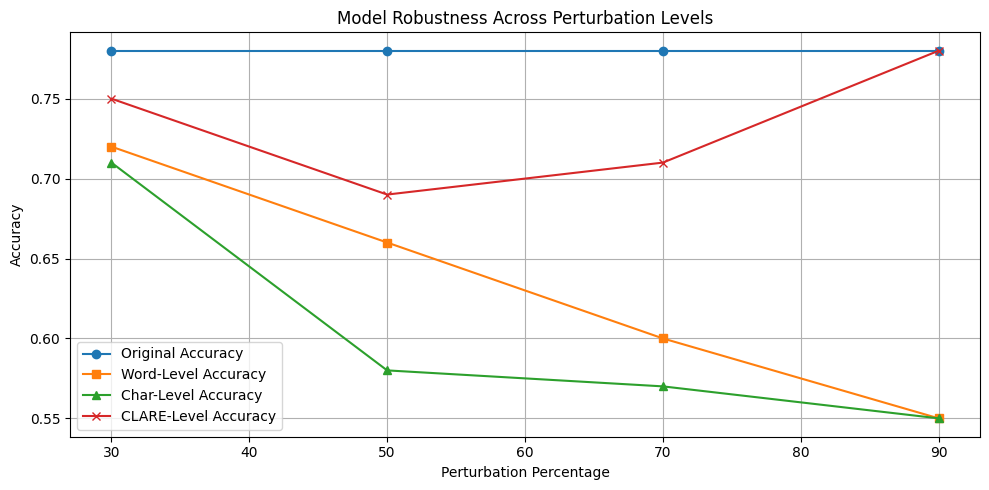

In [ ]:
# === Save CSV ===
df_results = pd.DataFrame(all_results)
df_results.to_csv("robustness_evaluation_results.csv", index=False)

# === Plot Accuracy ===
import matplotlib.pyplot as plt

grouped = df_results.groupby("perturbation_pct").mean(numeric_only=True)

plt.figure(figsize=(10, 5))
plt.plot(grouped.index, grouped["original_correct"], marker="o", label="Original Accuracy")
plt.plot(grouped.index, grouped["word_perturbed_correct"], marker="s", label="Word-Level Accuracy")
plt.plot(grouped.index, grouped["char_perturbed_correct"], marker="^", label="Char-Level Accuracy")
plt.plot(grouped.index, grouped["clare_perturbed_correct"], marker="x", label="CLARE-Level Accuracy")
plt.xlabel("Perturbation Percentage")
plt.ylabel("Accuracy")
plt.title("Model Robustness Across Perturbation Levels")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("robustness_accuracy_plot.png")
plt.show()

In [ ]:
import ast
import json

print("\n=== Qualitative Examples: Model got original correct but failed all 3 attacks at 30% perturbation ===")

vulnerable_cases = df_results[
    (df_results["perturbation_pct"] == 30) & # can modify these conditions to return 2 or 1 failures
    (df_results["original_correct"] == 1) &
    (
        (df_results["word_perturbed_correct"] == 0) |
        (df_results["char_perturbed_correct"] == 0) |
        (df_results["clare_perturbed_correct"] == 0)
    )
]

sampled = vulnerable_cases.sample(n=min(5, len(vulnerable_cases)), random_state=42)

for idx, row in sampled.iterrows():
    # Try to parse options from string safely
    raw_options = row["options"]
    try:
        options = ast.literal_eval(raw_options) if isinstance(raw_options, str) else raw_options
    except:
        try:
            options = json.loads(raw_options)
        except:
            options = ["Invalid", "Invalid", "Invalid", "Invalid"]

    def get_text(letter):
        if isinstance(letter, str) and letter in "ABCD":
            index = ord(letter) - ord("A")
            if 0 <= index < len(options):
                return options[index]
        return "Invalid"

    correct_text = get_text(row['correct_letter'])
    word_text = get_text(row['word_letter'])
    char_text = get_text(row['char_letter'])
    clare_text = get_text(row['clare_letter'])

    print("\n Perturbation Level: 30%")
    print("Question:", row['question'])
    print("Options:", options)
    print(f"Correct Answer: {row['correct_letter']} ({correct_text})")

    print(f"\n Word Attack:")
    print("Perturbed Question:", row.get('word_perturbed_question', 'N/A'))
    print(f"Prediction: {row['word_letter']} ({word_text})")

    print(f"\n Char Attack:")
    print("Perturbed Question:", row.get('char_perturbed_question', 'N/A'))
    print(f"Prediction: {row['char_letter']} ({char_text})")

    print(f"\n CLARE Attack:")
    print("Perturbed Question:", row.get('clare_perturbed_question', 'N/A'))
    print(f"Prediction: {row['clare_letter']} ({clare_text})")

    print("-" * 80)


=== Qualitative Examples: Model got original correct but failed all 3 attacks at 30% perturbation ===

 Perturbation Level: 30%
Question: The current bar clasp design used is:
Options: ['Mesio-occlusal rest', 'Disto-occlusal rest', 'Mesial or distal depending on the situation', 'Choice of the dentist']
Correct Answer: A (Mesio-occlusal rest)

 Word Attack:
Perturbed Question: The current bar grasp design victimized is:
Prediction: A (Mesio-occlusal rest)

 Char Attack:
Perturbed Question: The current bar lasp deign used is:
Prediction: A (Mesio-occlusal rest)

 CLARE Attack:
Perturbed Question: The current key clasp design used is:
Prediction: C (Mesial or distal depending on the situation)
--------------------------------------------------------------------------------

 Perturbation Level: 30%
Question: Which of the following is considered as high risk infant?
Options: ['Working mother', 'Antenatal preeclampsia', 'Third child', 'Twins']
Correct Answer: A (Working mother)

 Word Atta